# 📦 1. Preparación del Dataset

En esta sección se construyen los **dataset base:** a partir de 8 videos de entrada (4 para Entrenamiento/Validación y 4 para test), cada uno correspondiente a una etiqueta (*label*) distinta.

## 📋 **Proceso resumido**:
1. **Extracción de coordenadas** usando [MediaPipe Pose](https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker?hl=es-419) para identificar los **33 puntos clave del cuerpo**.
2. Cada punto proporciona **3 coordenadas** `(x, y, z)`, generando así **99 columnas** por frame, más **1 columna de etiqueta**.
3. Se procesan los videos de manera individual, guardando un **CSV por etiqueta**.
4. Finalmente, Para *train_val* y *test* se **unen los 4 CSVs** en un único archivo, listo para cargarse con **Pandas**.

## 💻 **Implementación**:
- Todo el proceso se encuentra encapsulado en la clase `Preparar_dataset`
- Principales métodos:
  - `Crea_carpetas()` → Genera la estructura de carpetas de trabajo.
  - `Extrae_frames()` → Extrae frames y coordenadas de cada video.
  - `une_csvs()` → Une los CSV individuales en un único ***dataset_completo.csv***.


In [1]:
from scripts.Preparar_dataset import Preparar_dataset
dataset=Preparar_dataset()
dataset.Crea_carpetas()
dataset.Extrae_frames()
dataset.une_csvs()

2025-08-14 16:09:22.135377: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 16:09:22.145616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755209362.158605   25195 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755209362.162399   25195 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755209362.172525   25195 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

/home/misa/GitHub/Timeless-Turing/data/processed_videos/train_val/OTRO.mp4 OTRO
/home/misa/GitHub/Timeless-Turing/data/processed_videos/train_val/BRAZOS_CRUZADOS.mp4 BRAZOS_CRUZADOS
/home/misa/GitHub/Timeless-Turing/data/processed_videos/train_val/FIRMES.mp4 FIRMES
/home/misa/GitHub/Timeless-Turing/data/processed_videos/train_val/POSICION_FETAL.mp4 POSICION_FETAL
/home/misa/GitHub/Timeless-Turing/data/processed_videos/test/OTRO.mp4 OTRO
/home/misa/GitHub/Timeless-Turing/data/processed_videos/test/BRAZOS_CRUZADOS.mp4 BRAZOS_CRUZADOS
/home/misa/GitHub/Timeless-Turing/data/processed_videos/test/FIRMES.mp4 FIRMES
/home/misa/GitHub/Timeless-Turing/data/processed_videos/test/POSICION_FETAL.mp4 POSICION_FETAL
/home/misa/GitHub/Timeless-Turing/data/processed_videos/PruebasConSujetos/Sujeto2_2.mp4 Sujeto2_2
/home/misa/GitHub/Timeless-Turing/data/processed_videos/PruebasConSujetos/Sujeto2_1.mp4 Sujeto2_1
/home/misa/GitHub/Timeless-Turing/data/processed_videos/PruebasConSujetos/Sujeto1_2.mp4 Suje

I0000 00:00:1755209364.007565   25195 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1755209364.014922   25352 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) Graphics (RPL-S)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1755209364.137706   25317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1755209364.220897   25326 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


KeyboardInterrupt: 

# 🤖 2. Entrenamiento del Modelo

En esta sección se desarrolla y entrena el **modelo de clasificación** utilizando el dataset previamente preparado.

## 📋 **Flujo del entrenamiento**:
1. **Carga de datos** (`cargar_datos`) → Lee los dataset unificados para *Entrenamiento + Validación* y *Prueba* y lo adapta al formato necesario para el entrenamiento.
2. **División del dataset** (`dividir_datos`) → Separa el dataset en:
   - **Entrenamiento** (*training set*) → Usado para ajustar los pesos del modelo.
   - **Validación** (*validation set*) → Usado para ajustar hiperparámetros y prevenir sobreajuste.
   - **Prueba** (*test set*) → Usado para medir el rendimiento final del modelo.
3. **Construcción de la arquitectura** (`construccion`) → Define las capas de la red neuronal y su configuración.
    
    🧱 Aquí definimos una **red neuronal densa (MLP)** pensada para **datos tabulares** (99 features por frame provenientes de coordenadas `(x,y,z)` de 33 puntos) y **clasificación multiclase**.

    ### 🏗️ Arquitectura
    - **Entrada**: `n_features` (p. ej., 99)  
    - **Bloques densos**:
    - `Dense(128, relu)` → `BatchNormalization()` → `Dropout(0.30)`
    - `Dense(64, relu)` → `BatchNormalization()` → `Dropout(0.30)`
    - **Salida**: `Dense(n_classes, softmax)`
    - **Compilación**: `Adam(lr=1e-3)`, `loss='categorical_crossentropy'`, `metrics=['accuracy']`

    ### 🤔 ¿Por qué esta arquitectura?
    - **Adecuada para tabular**: Las features ya son numéricas y “planas”. Un **MLP** explota bien relaciones no lineales sin necesidad de convoluciones o recorridos temporales.
    - **Capacidad y generalización balanceadas**:
        - **128 → 64 neuronas**: suficiente capacidad para capturar combinaciones entre 99 variables sin sobreparametrizar.
    - **ReLU**: activa solo lo útil, acelera el aprendizaje y evita saturaciones.
    - **Estabilización del entrenamiento**:
        - **BatchNormalization** reduce el *internal covariate shift*, permitiendo tasas de aprendizaje algo más altas y convergencia más estable.
    - **Regularización explícita**:
        - **Dropout(0.30)** en ambos bloques reduce co-adaptaciones y **mitiga el sobreajuste**, importante cuando cada video aporta muchos frames pero con correlaciones fuertes.
    - **Salida softmax + entropía cruzada**:
        - Es el estándar para **multiclase** con **etiquetas one-hot**, produce probabilidades bien calibradas y una función objetivo consistente.

    ### ⚙️ Hiperparámetros clave (y su razonamiento)
    - **Adam (1e-3)**: buen *default* para problemas tabulares; combina momento y adaptación por parámetro.  
    - **Tamaño de capas (128/64)**: escalado empírico típico para 50–200 features. Si observas *underfitting*, prueba 256/128; si hay *overfitting*, baja a 64/32.
    - **Dropout 0.30**: punto intermedio efectivo.
    - **BN + ReLU**: en este diseño BN va **después** de la activación; también es válido poner **BN antes** de la activación (estilo “pre-activation”). Si pruebas esa variante, pon `use_bias=False` en las capas densas.

4. **Entrenamiento** (`entrenamiento`) → Ajusta los pesos usando *training* y valida en cada época con *validation*, guardando el historial de métricas (*accuracy*, *loss*).
5. **Evaluación** (`evaluacion`) → Calcula el rendimiento final sobre el *test set*.
6. **Visualización** (`graficar_entrenamiento`) → Genera gráficas de precisión y pérdida para analizar el comportamiento durante el entrenamiento.

## 💻 **Implementación**:
- El flujo está encapsulado en la clase `Modelo`, ubicada en `scripts/Entrenamiento.py`.
- Permite **reproducir el entrenamiento completo** con una secuencia clara y modular de métodos.


Epoch 1/100
7/7 - 1s - 127ms/step - accuracy: 0.3903 - loss: 1.8125 - val_accuracy: 0.2134 - val_loss: 1.3406
Epoch 2/100
7/7 - 0s - 17ms/step - accuracy: 0.6906 - loss: 0.8743 - val_accuracy: 0.2110 - val_loss: 1.3023
Epoch 3/100
7/7 - 0s - 18ms/step - accuracy: 0.7956 - loss: 0.5775 - val_accuracy: 0.2278 - val_loss: 1.2566
Epoch 4/100
7/7 - 0s - 17ms/step - accuracy: 0.8513 - loss: 0.4332 - val_accuracy: 0.3381 - val_loss: 1.2143
Epoch 5/100
7/7 - 0s - 18ms/step - accuracy: 0.8663 - loss: 0.3703 - val_accuracy: 0.4700 - val_loss: 1.1750
Epoch 6/100
7/7 - 0s - 18ms/step - accuracy: 0.8927 - loss: 0.3173 - val_accuracy: 0.5300 - val_loss: 1.1449
Epoch 7/100
7/7 - 0s - 18ms/step - accuracy: 0.9155 - loss: 0.2774 - val_accuracy: 0.5588 - val_loss: 1.1231
Epoch 8/100
7/7 - 0s - 17ms/step - accuracy: 0.9227 - loss: 0.2375 - val_accuracy: 0.5875 - val_loss: 1.1044
Epoch 9/100
7/7 - 0s - 18ms/step - accuracy: 0.9287 - loss: 0.2156 - val_accuracy: 0.6595 - val_loss: 1.0723
Epoch 10/100
7/7 -

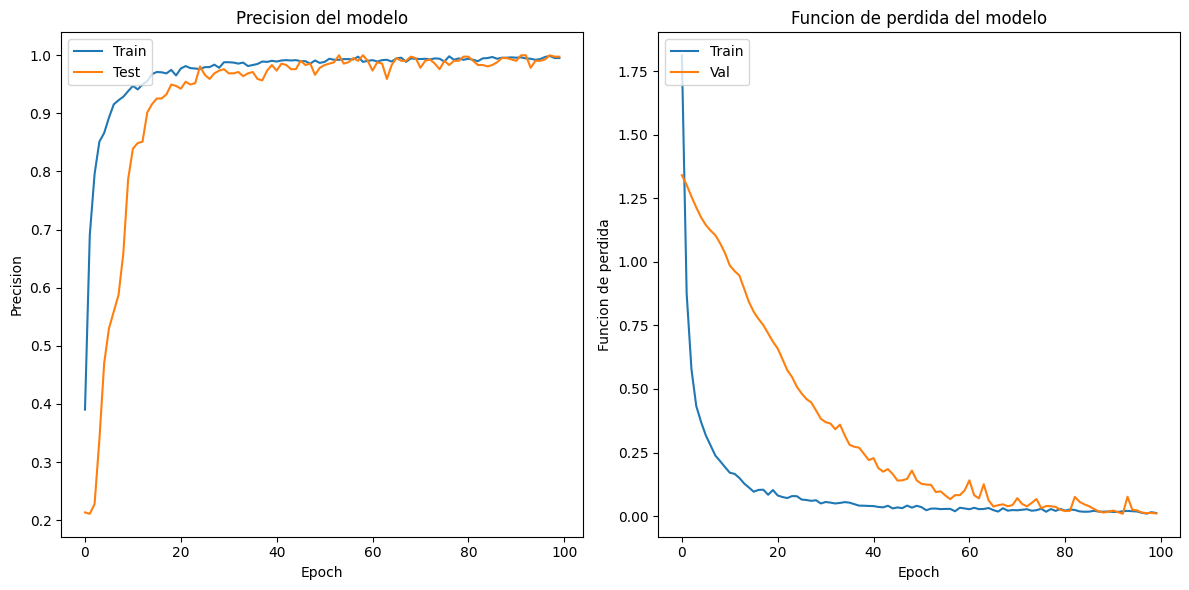

In [15]:
from scripts.Entrenamiento import Modelo
model=Modelo()
model.cargar_datos()
model.dividir_datos()
model.construccion()
history=model.entrenamiento()
model.evaluacion()
model.graficar_entrenamiento(history)

## 📊 3. Evaluación y Comparativa de Modelos Guardados

En esta sección se cargan y evalúan los **modelos previamente entrenados** al ejecutar la celda anterior, esto con el objetivo de:

- 📌 **Seleccionar el mejor modelo** para futuras predicciones.
- 🗑️ **Descartar modelos** que no alcancen un rendimiento aceptable.
- 📈 **Comparar** métricas clave de desempeño para una toma de decisión informada.

### 🔍 Flujo del proceso
1. **Localización de modelos**:  
   Se buscan en la carpeta `models/` todos los archivos con nombre `best_model*.keras`.
2. **Carga y evaluación**:  
   Cada modelo se carga con `load_model` y se evalúa contra el *test set* (`X_test`, `Y_oh_test`), obteniendo:
   - **Loss** (función de pérdida en test).
   - **Accuracy** en el conjunto de prueba.
3. **Generación de predicciones**:  
   Se predicen las clases del *test set*.
4. **Matriz de confusión (`confusion_matrix`)**:  
   Permite visualizar los aciertos y errores por clase.
5. **Reporte de clasificación (`classification_report`)**:  
   Incluye precisión (*precision*), exhaustividad (*recall*) y F1-score por clase.

### 📈 Interpretación esperada
- **Modelo ideal para predicción**:  
  Aquel con **alta precisión** y **balance entre clases** (sin que una clase en particular sea mucho peor).
- **Modelo candidato a descartar**:  
  Rendimiento notablemente inferior o métricas muy desequilibradas entre clases.


In [19]:
from pathlib import Path
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
#
X_test,Y_test,poses_lb=model.getX_test_Y_test_poses_lb()
model_path = Path ("models").resolve()
models = [p for p in model_path.rglob("best_model*.keras")]
for modelo in models:
    modelName=str(modelo)
    print(f'\n\n Modelo: {modelo.stem}')
    best_model = load_model(modelName)
    test_loss, test_acc = best_model.evaluate(X_test, Y_test, verbose=0)
    print(f"Accuracy en test: {test_acc:.3f}")


    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(Y_test.argmax(1), y_pred.argmax(1))
    print(cm)
    print(classification_report(Y_test.argmax(1), y_pred.argmax(1), target_names=poses_lb.classes_))



 Modelo: best_model_5
Accuracy en test: 0.885
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[[296  58   0   0]
 [  6 377   0   0]
 [ 19  58 410   0]
 [ 16  11   1 214]]
                 precision    recall  f1-score   support

BRAZOS_CRUZADOS       0.88      0.84      0.86       354
         FIRMES       0.75      0.98      0.85       383
           OTRO       1.00      0.84      0.91       487
 POSICION_FETAL       1.00      0.88      0.94       242

       accuracy                           0.88      1466
      macro avg       0.91      0.89      0.89      1466
   weighted avg       0.90      0.88      0.89      1466



 Modelo: best_model_8
Accuracy en test: 0.952
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[[349   5   0   0]
 [  2 378   3   0]
 [ 20  11 449   7]
 [ 17   1   4 220]]
                 precision    recall  f1-score   support

BRAZOS_CRUZADOS       0.90      0.99      0.94       354
         FIRMES       0.96      0.99      0.97       383
           OTRO       0.98      0.92   

## 🎯 4. Prueba del Modelo en Datos Reales

En esta sección se utiliza la clase `Tester` para cargar un **modelo previamente entrenado** y ponerlo a prueba con **videos e imágenes reales**.

### 📋 **Objetivos**:
- Validar el rendimiento del modelo en **condiciones reales** (fuera del dataset de entrenamiento y test).
- Analizar predicciones sobre **video continuo** y **fotografías estáticas**.
- Generar un registro de las poses detectadas (videos).

### 🔍 Flujo del proceso
1. **Carga del modelo y etiquetas** (`Carga_modelo`):  
   - Modelo: `models/best_model_17.keras` Es el que ha tenido mejor comportamiento general  
   - Mapeo de etiquetas: `models/mapeo_etiquetas.json` (traduce índices numéricos a nombres de poses).
2. **Predicción en video** (`Predice_video`):  
   - Analiza el archivo `Betza_1.mp4`.  
   - Opción `reproducir=False` para procesar sin mostrar el video.
3. **Predicción en imagen** (`Predice_imagen`):  
   - Analiza una fotografía individual (`foto8.jpeg`).  
   - Muestra la imagen con la predicción superpuesta (presionar `ESC` para cerrar).

### ⚙️ Lógica interna de la predicción
En el análisis de video, el proceso sigue este esquema:
1. **Verificación de puntos clave**:  
   Solo se procede si **MediaPipe Pose** detecta los **33 puntos** del cuerpo.
2. **Control de frecuencia de análisis**:  
   Se procesa un frame solo si `contador >= step` para **reducir carga de cómputo** (no analizar cada frame).
3. **Extracción de features**:  
   - `pose.extrae_valores()` → Vector `(99,)` con coordenadas `(x,y,z)` de los 33 puntos.
4. **Predicción**:  
   - `model.predict(X)` produce probabilidades para cada clase.  
   - `np.argmax` selecciona la clase con mayor probabilidad.
5. **Mapeo de etiqueta**:  
   - `mapeo_etiquetas` traduce el índice a nombre de la pose.
6. **Registro**:  
   - Guarda `[segundo, etiqueta]` en `self.data` fromando un registro final con las poses `csv`.

### 💡 Beneficios del diseño
- **Control de frecuencia (`step`)**: optimiza tiempo de cómputo y evita procesar frames redundantes.
- **Filtro por puntos detectados**: asegura calidad mínima de datos antes de predecir.
- **Registro**: útil para analizar cambios de pose a lo largo del video.

In [3]:
from scripts.Tester import Tester
prueba= Tester()
#
prueba.Carga_modelo(model_path          = "models/best_model_8.keras",
                    etiquetas_json_path = "models/mapeo_etiquetas.json")
#
#prueba.Predice_video(video_path         = "data/processed_videos/PruebasConSujetos/Sujeto1_1.mp4",
#                     reproducir         = True)
#
prueba.Predice_imagen(image_path        = "data/fotos/ChatGPT_PosicionFetal.png", muestra=True) # Presiona ESC para cerrar imagen


Analizando Imagen
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


I0000 00:00:1755212648.165776  150715 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1755212648.167314  152225 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) Graphics (RPL-S)
W0000 00:00:1755212648.207509  152194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1755212648.271583  152220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Pose: POSICION_FETAL
